# Development Pathways (2011–2023): Poverty, Life Expectancy, Economic Capacity, and Renewable Electricity

**Author:** Daniel Choi  
**Date:** December 15, 2025

## Introduction

Economic growth, poverty reduction, and improvements in population health are central goals of global development, yet countries have followed different paths in achieving these outcomes. While rising incomes are often associated with lower poverty and longer life expectancy, these relationships vary substantially across countries over time. At the same time, development has occurred alongside different patterns of energy use, raising questions about the sustainability of these gains.

In this project, I analyze global development patterns from **2011 to 2023** using a country-level dataset that combines four key indicators:

- **GDP per capita (PPP)** as a measure of economic capacity  
- **Share of the population living in extreme poverty** as a measure of material deprivation  
- **Life expectancy at birth** as a broad indicator of population health  
- **Renewable electricity generation per capita** as a lens on sustainable development pathways  

Together, these indicators allow for meaningful comparisons across countries and over time. GDP per capita provides economic context, poverty rates capture how resources are distributed within countries, and life expectancy reflects human well-being outcomes. Renewable electricity generation is normalized by population to enable fair comparison across countries of different sizes and to highlight differences in development pathways.

The goal of this analysis is to examine **how poverty reduction and life expectancy are associated with economic growth across countries** and **how renewable energy adoption varies across these development pathways**. I address this question using **comparative visualizations**, including time trends, maps, and relationship plots, to highlight broad patterns and contrasts without making causal claims.

## Data Description

This project uses a **country-level panel dataset** covering the period **2011–2023** to examine global development patterns across economic, social, and environmental dimensions. The unit of analysis is a **country–year**, enabling cross-country comparison and analysis of changes over time.

The analysis combines the following indicators drawn from widely used international data sources:

### Economic Capacity
- **GDP per capita (PPP, constant international dollars)**  
  GDP per capita provides a standardized measure of average economic output and serves as contextual information about a country’s economic capacity.

### Poverty
- **Share of the population living in extreme poverty**  
  This variable measures the proportion of a country’s population living below an internationally defined extreme poverty threshold, allowing for meaningful comparison across countries of different sizes.

### Population Health
- **Life expectancy at birth**  
  Life expectancy is used as a broad indicator of population health and overall well-being.

### Sustainability
- **Renewable electricity generation per capita**  
  Renewable electricity generation is used as a sustainability lens rather than a direct welfare measure. Electricity generated from solar, wind, hydro, and other renewable sources is aggregated and normalized by population to enable cross-country comparison.

### Data Integration and Scope

All datasets are merged using standardized country identifiers and year, resulting in a unified country–year dataset. The analysis is restricted to **2011–2023**, the period for which all indicators are jointly observed. Countries with missing values for required variables are excluded from analyses that depend on those measures to ensure consistency and transparency.

## Data Preparation and Integration

Before conducting exploratory analysis, all datasets are cleaned and integrated into a single, consistent country–year panel. This preparation step ensures that comparisons across economic capacity, poverty, health outcomes, and renewable energy use are based on a shared structure and timeframe.

All datasets are first restricted to the period **2011–2023**, the most recent window for which all variables are jointly observed. Country identifiers and year variables are standardized, and only the columns required for analysis are retained. Variables are renamed for clarity and consistency.

Renewable electricity generation is aggregated across solar, wind, hydro, and other renewable sources. Population data are then merged into the dataset, and renewable electricity is converted to a **per-capita measure** to enable meaningful comparison across countries of different sizes.

The datasets are merged using **country and year** as join keys to create a unified master dataset. Observations missing required variables are excluded from analyses that depend on those measures to ensure transparency and reproducibility. This integrated dataset serves as the foundation for all subsequent exploratory and comparative visualizations, including static, interactive, and geospatial plots.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import altair as alt
import plotly.express as px

In [3]:
gdp_raw = pd.read_csv("data/gdp-per-capita-worldbank.csv")
life_raw = pd.read_csv("data/life-expectancy-hmd-unwpp.csv")
poverty_raw = pd.read_csv("data/share-of-population-living-in-extreme-poverty.csv")
renew_raw = pd.read_csv("data/modern-renewable-energy-consumption.csv")
pop_raw = pd.read_csv("data/population-with-un-projections.csv")

In [4]:
gdp = (
    gdp_raw.loc[
        (gdp_raw["Year"] >= 2011) & (gdp_raw["Year"] <= 2023),
        ["Entity", "Code", "Year", "GDP per capita, PPP (constant 2021 international $)"]
    ]
    .rename(columns={
        "Entity": "country",
        "Code": "iso_code",
        "Year": "year",
        "GDP per capita, PPP (constant 2021 international $)": "gdp_per_capita"
    })
)

life_exp = (
    life_raw.loc[
        (life_raw["Year"] >= 2011) & (life_raw["Year"] <= 2023),
        ["Entity", "Code", "Year",
         "Life expectancy - Sex: total - Age: 0 - Type: period"]
    ]
    .rename(columns={
        "Entity": "country",
        "Code": "iso_code",
        "Year": "year",
        "Life expectancy - Sex: total - Age: 0 - Type: period": "life_expectancy"
    })
)

poverty = (
    poverty_raw.loc[
        (poverty_raw["Year"] >= 2011) & (poverty_raw["Year"] <= 2023),
        ["Country", "Year", "Share below $3 a day"]
    ]
    .rename(columns={
        "Country": "country",
        "Year": "year",
        "Share below $3 a day": "poverty_rate"
    })
)

renewables = (
    renew_raw.loc[
        (renew_raw["Year"] >= 2011) & (renew_raw["Year"] <= 2023),
        [
            "Entity", "Code", "Year",
            "Solar generation - TWh",
            "Wind generation - TWh",
            "Hydro generation - TWh",
            "Other renewables (including geothermal and biomass) electricity generation - TWh"
        ]
    ]
    .rename(columns={
        "Entity": "country",
        "Code": "iso_code",
        "Year": "year"
    })
)

renewables["renewable_electricity_twh"] = (
    renewables["Solar generation - TWh"]
    + renewables["Wind generation - TWh"]
    + renewables["Hydro generation - TWh"]
    + renewables["Other renewables (including geothermal and biomass) electricity generation - TWh"]
)

renewables = renewables[["country", "iso_code", "year", "renewable_electricity_twh"]]

population = (
    pop_raw.loc[
        (pop_raw["Year"] >= 2011) & (pop_raw["Year"] <= 2023),
        ["Entity", "Code", "Year", "Population - Sex: all - Age: all - Variant: estimates"]
    ]
    .rename(columns={
        "Entity": "country",
        "Code": "iso_code",
        "Year": "year",
        "Population - Sex: all - Age: all - Variant: estimates": "population"
    })
)

In [5]:
df = (
    gdp
    .merge(life_exp, on=["country", "iso_code", "year"], how="inner")
    .merge(poverty, on=["country", "year"], how="inner")
    .merge(renewables, on=["country", "iso_code", "year"], how="inner")
    .merge(population, on=["country", "iso_code", "year"], how="inner")
)

df["renewable_electricity_kwh_per_capita"] = (
    df["renewable_electricity_twh"] * 1e9
) / df["population"]

print("Column Names:\n", df.columns)
print("\nDataframe Shape:\n", df.shape)
df.head()

Column Names:
 Index(['country', 'iso_code', 'year', 'gdp_per_capita', 'life_expectancy',
       'poverty_rate', 'renewable_electricity_twh', 'population',
       'renewable_electricity_kwh_per_capita'],
      dtype='object')

Dataframe Shape:
 (662, 9)


,country,iso_code,year,gdp_per_capita,life_expectancy,poverty_rate,renewable_electricity_twh,population,renewable_electricity_kwh_per_capita
0,Algeria,DZA,2011,14641.964,74.3834,0.000000,0.396119,36903374.0,10.733944
1,Australia,AUS,2014,55288.117,82.5182,0.498484,32.759362,23595599.0,1388.367466
2,Australia,AUS,2016,56341.520,82.8014,0.498742,41.736415,24329963.0,1715.432716
3,Australia,AUS,2018,57450.383,83.2582,0.497094,49.493547,25119700.0,1970.308045
4,Australia,AUS,2020,57059.742,83.6639,0.989208,64.282814,25743787.0,2497.022454


## Data Dictionary

The table below documents the key variables used in the analysis, including their definitions, units, data sources, and any transformations applied. All variables are measured at the country–year level for the period **2011–2023**.

| Variable Name | Description | Units | Source | Transformations |
|--------------|-------------|-------|--------|------------------|
| `country` | Country name | N/A | Our World in Data | None |
| `year` | Calendar year | Year | Our World in Data | Restricted to 2011–2023 |
| `gdp_per_capita` | Gross domestic product per capita adjusted for purchasing power parity | Constant international dollars | World Bank (via OWID) | Log-transformed in selected visualizations |
| `poverty_rate` | Share of the population living below the international extreme poverty line | Percent (%) | World Bank / OWID | None |
| `life_expectancy` | Life expectancy at birth for the total population | Years | UN World Population Prospects / Human Mortality Database (via OWID) | Used in population-weighted averages |
| `population` | Total population | Persons | UN World Population Prospects (via OWID) | Used as weights and to compute per-capita values |
| `renewable_electricity_kwh_per_capita` | Renewable electricity generation per person | Kilowatt-hours per capita | Our World in Data | Computed from total renewable electricity generation (TWh) divided by population |

## Exploratory Data Analysis

Before examining specific development pathways, I begin with a brief exploratory analysis to understand the structure, coverage, and basic patterns in the data. This section focuses on high-level trends and distributions to provide context for later comparisons, rather than drawing substantive conclusions.  


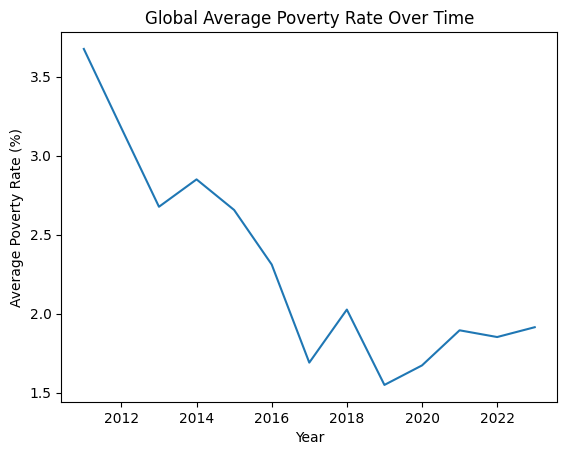

In [6]:
poverty_trend = (
    df.groupby("year", as_index=False)["poverty_rate"]
      .mean()
)

plt.figure()
plt.plot(poverty_trend["year"], poverty_trend["poverty_rate"])
plt.xlabel("Year")
plt.ylabel("Average Poverty Rate (%)")
plt.title("Global Average Poverty Rate Over Time")
plt.show()

The global average poverty rate declines steadily over this period, consistent with widely documented reductions in extreme poverty since 2000.

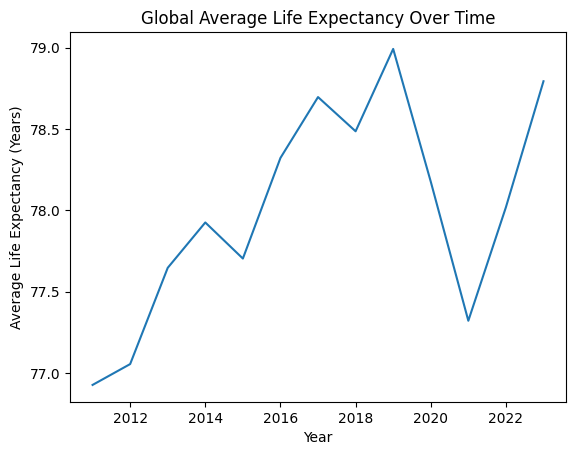

In [7]:
avg_life_exp = (
    df.groupby("year")["life_expectancy"]
      .mean()
)

# Plot
plt.figure()
plt.plot(avg_life_exp.index, avg_life_exp.values)
plt.xlabel("Year")
plt.ylabel("Average Life Expectancy (Years)")
plt.title("Global Average Life Expectancy Over Time")
plt.show()

Average life expectancy generally increases over time, reflecting broad improvements in population health across countries. However, we can observe a sharp decline in global life expectancy around 2020–2021 reflecting the mortality impact of the COVID-19 pandemic. This dip is more pronounced when life expectancy is computed as a population-weighted average.


### Distributions and Cross-Country Variation

To better understand how development outcomes vary across countries, I next examine the distributions of key variables. These plots highlight the extent of cross-country heterogeneity and help motivate later comparative analyses.

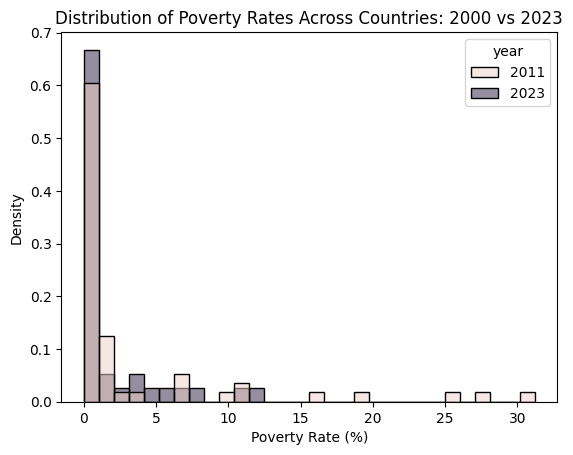

In [8]:
df_dist = df[df["year"].isin([2011, 2023])]

plt.figure()
sns.histplot(
    data=df_dist,
    x="poverty_rate",
    hue="year",
    bins=30,
    stat="density", 
    common_norm=False
)
plt.xlabel("Poverty Rate (%)")
plt.title("Distribution of Poverty Rates Across Countries: 2000 vs 2023")
plt.show()

The distribution of country-level poverty rates shifts toward lower values over time, while substantial variation across countries remains.

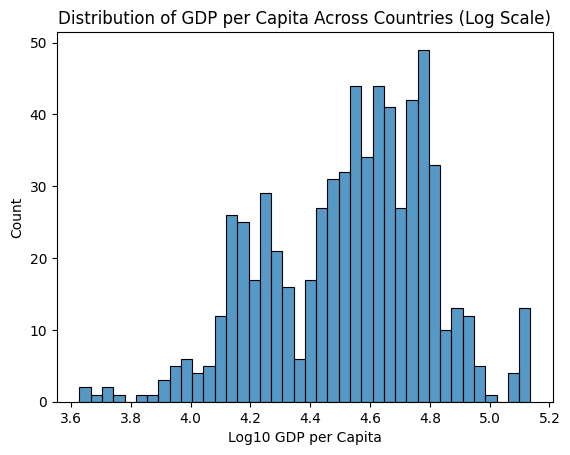

In [9]:
plt.figure()
sns.histplot(
    np.log10(df["gdp_per_capita"]),
    bins=40
)
plt.xlabel("Log10 GDP per Capita")
plt.title("Distribution of GDP per Capita Across Countries (Log Scale)")
plt.show()

GDP per capita exhibits a highly skewed distribution, with most countries clustered at lower income levels and a small number of high-income outliers.

### Initial Relationships

In this final EDA step, I explore basic relationships between key development indicators to preview how poverty, health outcomes, and economic capacity vary together across countries. These plots are intended to highlight broad associations rather than establish causal relationships.

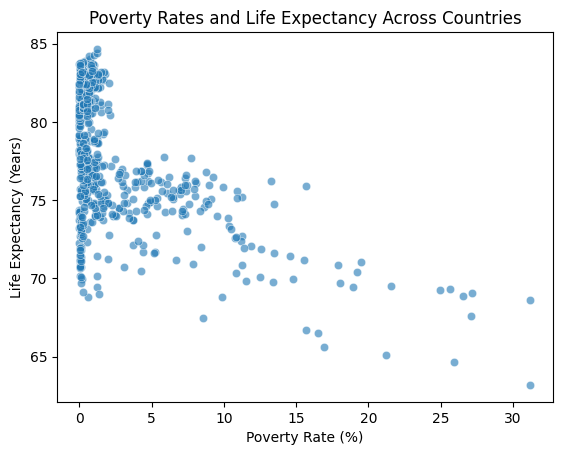

In [10]:
plt.figure()
sns.scatterplot(
    data=df,
    x="poverty_rate",
    y="life_expectancy",
    alpha=0.6
)
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Life Expectancy (Years)")
plt.title("Poverty Rates and Life Expectancy Across Countries")
plt.show()

Countries with higher poverty rates tend to have lower life expectancy, though there is substantial variation across the distribution.

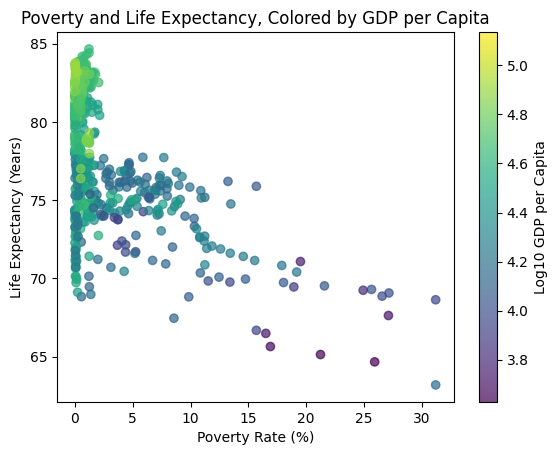

In [11]:
plt.figure()

sc = plt.scatter(
    df["poverty_rate"],
    df["life_expectancy"],
    c=np.log10(df["gdp_per_capita"]),
    cmap="viridis",
    alpha=0.7
)

plt.xlabel("Poverty Rate (%)")
plt.ylabel("Life Expectancy (Years)")
plt.title("Poverty and Life Expectancy, Colored by GDP per Capita")

cbar = plt.colorbar(sc)
cbar.set_label("Log10 GDP per Capita")

plt.show()

Countries with higher poverty rates generally exhibit lower life expectancy, while higher-income countries, shown in lighter colors, tend to cluster at lower poverty levels and higher life expectancy.

## Results

This section presents the main findings of the analysis, focusing on how poverty reduction and life expectancy relate to economic growth across countries, and how renewable energy adoption varies across these development pathways. The results emphasize comparative patterns observed in the data rather than causal relationships.

### Economic Growth, Poverty, and Life Expectancy

I first examine the relationship between economic capacity, poverty reduction, and population health across countries. Together, these indicators illustrate how improvements in income are associated with both material well-being and health outcomes, while also revealing substantial cross-country variation.

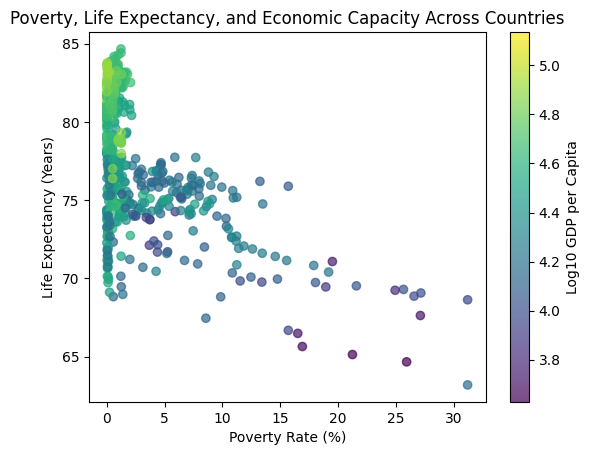

In [12]:
plt.figure()

sc = plt.scatter(
    df["poverty_rate"],
    df["life_expectancy"],
    c=np.log10(df["gdp_per_capita"]),
    cmap="viridis",
    alpha=0.7
)

plt.xlabel("Poverty Rate (%)")
plt.ylabel("Life Expectancy (Years)")
plt.title("Poverty, Life Expectancy, and Economic Capacity Across Countries")

cbar = plt.colorbar(sc)
cbar.set_label("Log10 GDP per Capita")

plt.show()

The relationship between poverty and life expectancy is strongly structured by economic capacity. Higher-income countries cluster at low poverty rates and high life expectancy, whereas lower-income countries span a broader range of outcomes, indicating divergent development trajectories even at similar income levels.

### Development Pathways and Renewable Energy

Renewable energy adoption provides a sustainability lens through which to compare development pathways across countries. Rather than serving as a direct measure of welfare, renewable electricity generation highlights how countries at different income and health levels pursue energy transitions alongside broader development goals.

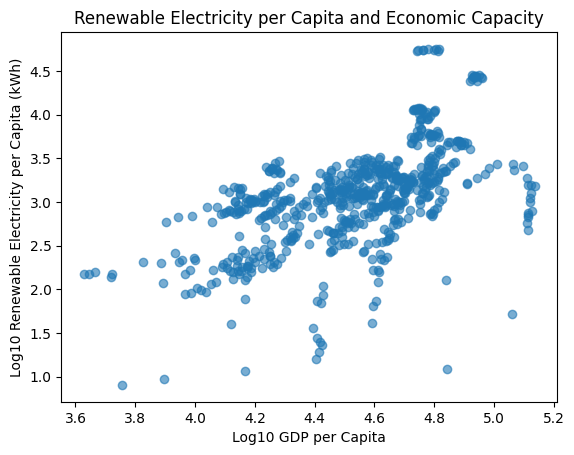

In [13]:
plt.figure()

plt.scatter(
    np.log10(df["gdp_per_capita"]),
    np.log10(df["renewable_electricity_kwh_per_capita"] + 1),
    alpha=0.6
)

plt.xlabel("Log10 GDP per Capita")
plt.ylabel("Log10 Renewable Electricity per Capita (kWh)")
plt.title("Renewable Electricity per Capita and Economic Capacity")

plt.show()

Renewable electricity availability per capita generally increases with economic capacity, though substantial dispersion across income levels indicates that countries with similar GDP per capita often pursue different renewable energy pathways.

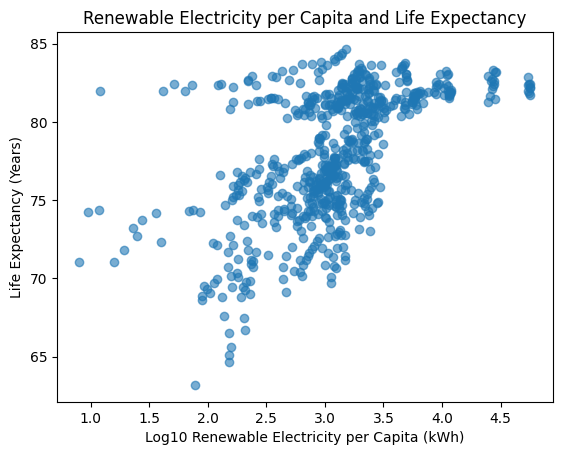

In [14]:
plt.figure()

plt.scatter(
    np.log10(df["renewable_electricity_kwh_per_capita"] + 1),
    df["life_expectancy"],
    alpha=0.6
)

plt.xlabel("Log10 Renewable Electricity per Capita (kWh)")
plt.ylabel("Life Expectancy (Years)")
plt.title("Renewable Electricity per Capita and Life Expectancy")

plt.show()

Renewable electricity availability per capita varies substantially across countries with similar life expectancy. While higher life expectancy is generally associated with greater renewable electricity availability, the wide dispersion suggests that renewable energy adoption reflects diverse development pathways rather than a single trajectory.

Overall, the results show that poverty reduction and improvements in life expectancy are closely associated with economic growth across countries, while renewable energy adoption varies widely within these development pathways, reflecting diverse approaches to sustainable development.

## Interactive Mini-Dashboard: Exploring Development Patterns Over Time

To complement the static exploratory and results-based visualizations, this section presents an interactive mini-dashboard that allows users to explore global development patterns dynamically. Using interactive controls and hover-based exploration, the dashboard links multiple indicators, poverty, life expectancy, economic capacity, and renewable energy, across countries and over time. This interactive view highlights heterogeneity and temporal change that are difficult to capture in static figures, and enables deeper exploration of development pathways across countries.

In [15]:
fig_scatter = px.scatter(
    df,
    x="poverty_rate",
    y="life_expectancy",
    color="gdp_per_capita",
    hover_name="country",
    animation_frame="year",
    color_continuous_scale="Viridis",
    labels={
        "poverty_rate": "Poverty rate (%)",
        "life_expectancy": "Life expectancy (years)",
        "gdp_per_capita": "GDP per capita"
    },
    title="Poverty and Life Expectancy Over Time"
)

fig_scatter.update_traces(marker=dict(opacity=0.7))

fig_scatter.update_layout(
    autosize=True, 
    height=700,
    margin=dict(l=80, r=40, t=80, b=60),
    font=dict(size=14),
    title_font=dict(size=20)
)

fig_scatter.show()

In [16]:
df_bar = (
    df.dropna(subset=["renewable_electricity_kwh_per_capita"])
      .sort_values(["year", "renewable_electricity_kwh_per_capita"], ascending=[True, False])
      .groupby("year")
      .head(15)
)

fig_bar = px.bar(
    df_bar,
    x="renewable_electricity_kwh_per_capita",
    y="country",
    orientation="h",
    animation_frame="year",
    labels={
        "renewable_electricity_kwh_per_capita": "Renewable electricity (kWh per capita)"
    },
    title="Top 15 Countries by Renewable Electricity per Capita Over Time"
)

fig_bar.update_yaxes(autorange="reversed")

fig_bar.update_layout(
    autosize=True,
    height=700,
    margin=dict(l=220, r=60, t=90, b=70),
    font=dict(size=14),
    title_font=dict(size=20)
)

fig_bar.show()

**Notable Patterns.**  
Exploring the interactive visualizations reveals several consistent patterns. Countries with higher GDP per capita tend to exhibit higher life expectancy and cluster in the low-poverty, high-health region of the scatter plot across most years. In addition, higher-income countries appear more frequently among the top 15 countries by renewable electricity generation per capita, suggesting that greater economic capacity is often associated with stronger adoption of renewable energy technologies. While these relationships are descriptive rather than causal, the interactive views highlight how economic capacity, health outcomes, and energy pathways tend to align across countries over time.

More broadly, the interactive dashboard highlights substantial heterogeneity in development outcomes across countries and years. While higher GDP per capita is generally associated with lower poverty and higher life expectancy, the strength and consistency of these relationships vary across countries. The renewable electricity view further illustrates that countries at similar income levels can follow very different energy pathways, reinforcing the importance of examining multiple dimensions of development simultaneously.

## Discussion

The results highlight clear and consistent relationships between economic capacity, poverty, population health, and renewable energy adoption, while also revealing substantial heterogeneity in development pathways across countries.

First, the negative association between poverty rates and life expectancy underscores the close link between material deprivation and population health. Countries with lower poverty rates tend to achieve substantially higher life expectancy, and this relationship is strongly structured by economic capacity. Higher-income countries cluster at low poverty and high life expectancy, while lower-income countries exhibit wider variation in outcomes. This pattern suggests that while economic growth plays an important role in improving health outcomes, it does not guarantee uniform gains across countries.

Second, the relationship between renewable electricity availability per capita and economic capacity indicates that wealthier countries generally have greater access to renewable electricity on a per-person basis. However, the wide dispersion observed across income levels suggests that renewable energy adoption is not determined by income alone. Countries with similar GDP per capita often display markedly different levels of renewable electricity availability, reflecting differences in policy choices, energy resources, and development priorities.

Finally, the relationship between renewable electricity per capita and life expectancy is positive but diffuse. Countries with higher life expectancy tend to have greater renewable electricity availability per person, yet substantial overlap exists across health outcomes. This pattern indicates that renewable energy adoption often accompanies broader development improvements but is not a direct determinant of population health. Instead, renewable energy appears to function as one component of a broader development pathway rather than a singular driver of well-being.

Taken together, these findings suggest that economic growth, poverty reduction, and improvements in health are closely interconnected, while renewable energy adoption varies widely within these development trajectories. The results emphasize the importance of considering multiple dimensions of development simultaneously when evaluating progress toward sustainable and equitable outcomes.

## Limitations

This analysis has several limitations. First, the merged dataset is restricted to **2011–2023**, reflecting differences in data availability across sources, which limits the ability to examine longer-term historical trends. Second, the analysis is observational and relies on country-level aggregates, preventing causal interpretation and masking within-country variation. Measures such as GDP per capita and renewable electricity per capita capture broad structural conditions but do not reflect inequality, energy access, or distributional outcomes within countries. Finally, renewable electricity adoption is influenced by factors not captured in the dataset, including policy frameworks, geographic endowments, and technological constraints. These limitations suggest that the results should be interpreted as descriptive patterns rather than definitive explanations.

## Conclusion

This project examined global development patterns by analyzing the relationships between economic capacity, poverty, population health, and renewable energy adoption across countries from 2011 to 2023. The results show that lower poverty rates and higher life expectancy are closely associated with greater economic capacity, while renewable electricity availability per capita increases with income but varies widely across countries at similar development levels. Together, these findings highlight the interconnected yet heterogeneous nature of development pathways and emphasize the value of using comparative visualizations to understand multidimensional progress toward sustainable and equitable outcomes.